In [1]:
#############################################
# PINN with causality-based loss for 1D SWE
#############################################

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
from scipy.stats import qmc

**Setup and Train PINN:**

In [6]:
# Domain
X = torch.tensor([-1.0, 1.0])   # spatial domain
T = torch.tensor([0.0, 1.0])    # temporal domain
g = 1

# choose causality domain
caus_l = 'XT' # 'T'/'X'/'TX'

# initial condition function Gaussian h
def initial_h(x):
    a = 0.2# amplitude
    m = 0.5 # offset
    sigma = 0.1 # standard deviation
    y = a * torch.exp(-x**2 / (2 * sigma**2)) + m
    return y

# Boundary condition points
n_bc = int(5e2)
t_bc = torch.linspace(T[0], T[1], n_bc)
t_bc = torch.cat((t_bc, t_bc))
x_bc = torch.cat((X[0] * torch.ones(n_bc), X[1] * torch.ones(n_bc)))

# Residuals points
n_col = int(1e4)
sob = qmc.Sobol(d=2, seed=42)  # setting seed for reproducibility
pts_raw = sob.random(n_col)
pts = torch.tensor(qmc.scale(pts_raw, [X[0].item(), T[0].item()], [X[1].item(), T[1].item()]), dtype=torch.float32)
x_col = pts[:, 0]
t_col = pts[:, 1]

# Sort according to causality dimension
if caus_l == 'T':
    caus_sort = t_col
elif caus_l == 'X':
    caus_sort = torch.abs(x_col)
elif caus_l == 'XT':
    caus_sort = torch.sqrt(t_col**2 + x_col**2)

idx_sort = torch.argsort(caus_sort)
t_col = t_col[idx_sort]
x_col = x_col[idx_sort]
caus_sort = caus_sort[idx_sort]

# stack sample points
t_in = torch.cat((t_col, t_bc))
x_in = torch.cat((x_col, x_bc))
# index seperating residual from boundary points
indices = n_col - 1

# send sample points to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
in_pinn = torch.cat((t_in.reshape(-1, 1), x_in.reshape(-1, 1)), dim=1).to(device)
in_pinn.requires_grad_(True);

# define PINN class
class PINN(nn.Module):
    # initialize model
    def __init__(self, n_in, n_l, n_n, n_out,fct_IC):
        super(PINN,self).__init__()
        self.layers = nn.ModuleList()
        self.fct_IC = fct_IC

        # define model layout
        # input layer
        self.layers.append(nn.Linear(n_in, n_n))
        self.layers.append(nn.Tanh())
        #hidden layers
        for i in range(n_l-1):
            self.layers.append(nn.Linear(n_n, n_n))
            self.layers.append(nn.Tanh())
        # output layer
        self.layers.append(nn.Linear(n_n, n_out))

        # initialize weights and biases
        for layer in self.layers:
            if isinstance(layer,nn.Linear):
                layer.weight = torch.nn.init.xavier_uniform_(layer.weight) # xavier_normal_
                layer.bias = torch.nn.init.zeros_(layer.bias)

    # forward propagation
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    # hard constrain IC
    def pred_hpinn(self,x):
        h_ic = self.fct_IC(x[:,1],)
        h_ic2 = torch.hstack((h_ic.reshape(-1,1), torch.zeros_like(h_ic).reshape(-1,1)))
        pred = h_ic2 + x[:,0].unsqueeze(1)*self.forward(x)
        return pred 

# calculate PDE and B.C. resiudals
def res_pinn(input,prediction,indices):
    h = prediction[:,0:1]
    dh = torch.autograd.grad(h.sum(),input, create_graph=True, retain_graph=True)
    dhdt = dh[0][:,0:1]
    dhdx = dh[0][:,1:2]
    hu = prediction[:,1:2]
    dhu = torch.autograd.grad(hu.sum(),input, create_graph=True, retain_graph=True)
    dhudt = dhu[0][:,0:1]
    dhudx = dhu[0][:,1:2]
    flux = hu**2/h+0.5*g*h**2
    dflux = torch.autograd.grad(flux.sum(),input, create_graph=True, retain_graph=True)
    dfluxdx = dflux[0][:,1:2]
    # mass conservation
    pde1 = dhdt[:indices] + dhudx[:indices]
    res1_pde = (pde1).pow(2)
    # momentum conservation
    pde2 = dhudt[:indices] + dfluxdx[:indices]
    res2_pde = (pde2).pow(2)
    # boundary condition
    res1_bc = (dhdx[indices+1:]).pow(2)
    res2_bc = (dhudx[indices+1:]).pow(2)
    # stack to return
    res_pde = torch.cat((res1_pde, res2_pde), dim=1)
    res_bc = torch.cat((res1_bc, res2_bc), dim=1)
    return res_pde, res_bc

# continuous causality loss
def causality_cont(res, epsilon):
    weights = torch.exp(-epsilon*torch.hstack([torch.tensor(0, device=res.device), torch.cumsum(res,0)[:-1].detach()]))
    losses = weights*res
    loss = torch.sum(losses)/weights.mean()/len(res)
    weights_tensor = weights[::1000]    # for illustration only
    return loss, weights_tensor

# Network Parameters
n_l = 5                             # number of hidden layers
n_n = 30                            # number of neurons per layer
n_in = in_pinn.shape[1]             # number of inputs
n_out = 2                           # number of outputs
n_epoch = int(5e4+1)                # number of training iterations
weights = torch.tensor([1,1,1,1],dtype=torch.float32,requires_grad=True).to(device) # loss weights order [h_caus hu_caus h_bc hu_bc]
epsilon = 1

# Initialize Network
SWE_pinn = PINN(n_in, n_l, n_n, n_out, initial_h)
SWE_pinn.to(device)
    
# predimensionalize storage container (for illustration only)
residuals_list = torch.empty((n_epoch // 100, len(weights)))
weights_caus = torch.empty((n_epoch // 100, 2*10))
epoch_list = torch.empty(n_epoch // 100)
  
# define optimizer
learninRate = 0.001
optimizer = torch.optim.Adam(SWE_pinn.parameters(), lr=learninRate)
    
# Training loop
start_time = time.time()

for epoch in range(n_epoch):
    optimizer.zero_grad() # reset gradients
    residuals = torch.zeros(4, device=device)

    # Prediction PINN
    pred_pinn = SWE_pinn.pred_hpinn(in_pinn)

    # Loss PINN
    res_pde, res_bc = res_pinn(in_pinn, pred_pinn, indices)
            
    # PDE loss with contnuous causality scheme
    residuals[0], w1_caus = causality_cont(res_pde[:,0], epsilon)  
    residuals[1], w2_caus = causality_cont(res_pde[:,1], epsilon)
        
    # BC loss
    residuals[2] = res_bc[:,0].mean()
    residuals[3] = res_bc[:,1].mean()
            
    # total loss
    loss = torch.sum(residuals * weights)
    loss.backward()

    # optimization and update
    optimizer.step()

    # write interim results
    if epoch % 100 == 0:
        index = epoch // 100 -1
        residuals_list[index, :] = residuals.detach()
        weights_caus[index, :] = torch.hstack((w1_caus, w2_caus))
        epoch_list[index] = epoch

    # display progress
    if epoch % 10000 == 0:
        elapsed = time.time() - start_time
        print('Epoch: ', epoch, 'Time', elapsed )

/opt/conda/lib/python3.10/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Epoch:  0 Time 0.5284230709075928
Epoch:  10000 Time 112.43018007278442


**Display Results:**

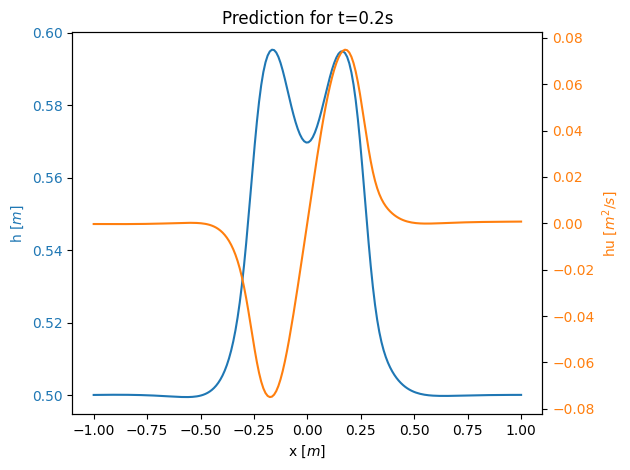

In [7]:
# display prediction
t_exp = 0.2
x_exp = np.linspace(X[0],X[1],200);
in_exp = torch.FloatTensor(np.hstack((t_exp*np.ones_like(x_exp).reshape(-1,1), x_exp.reshape(-1,1)))).to(device)
out = SWE_pinn.pred_hpinn(in_exp).cpu()
#plt.plot(x_exp,out[:,0].detach().numpy())
#plt.plot(x_exp,out[:,1].detach().numpy())

fig, ax1 = plt.subplots()
# Plot the first series with the left y-axis
ax1.plot(x_exp, out[:, 0].detach().numpy(), color='#1f77b4')
ax1.set_xlabel(r'x [$m$]')
ax1.set_ylabel(r'h [$m$]', color='#1f77b4')
ax1.tick_params(axis='y', labelcolor='#1f77b4')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(x_exp, out[:, 1].detach().numpy(), color='#ff7f0e')
ax2.set_ylabel(r'hu [$m^2/s$]', color='#ff7f0e')
ax2.tick_params(axis='y', labelcolor='#ff7f0e')

# Add a title and grid for clarity
plt.title(f'Prediction for t={str(t_exp)}s')
fig.tight_layout()
plt.show()

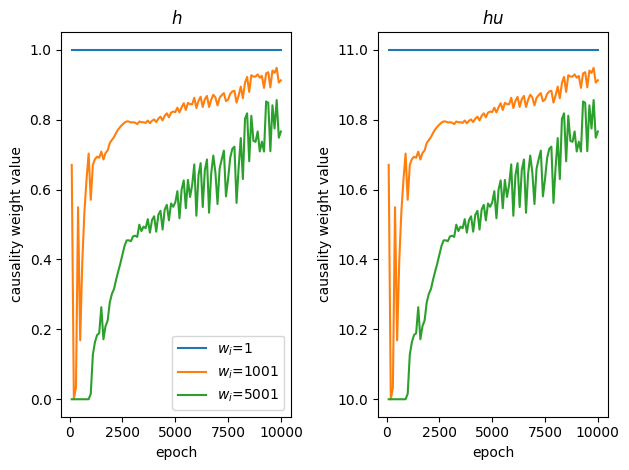

In [8]:
# causality losses
fig, ax = plt.subplots(1,2)

for i in [0,1,5]:
    ax[0].plot(epoch_list,weights_caus[:,i], label=fr'$w_i$={i*1000+1}')
    ax[1].plot(epoch_list,weights_caus[:,i]+10)

ax[0].set_title(r'$h$'); ax[1].set_title(r'$hu$')
ax[0].set_xlabel('epoch'); ax[1].set_xlabel('epoch')
ax[0].set_ylabel(r'causality weight value'); ax[1].set_ylabel(r'causality weight value')
ax[0].legend(loc='lower right')
fig.suptitle('causality weights')
fig.tight_layout()
plt.show()

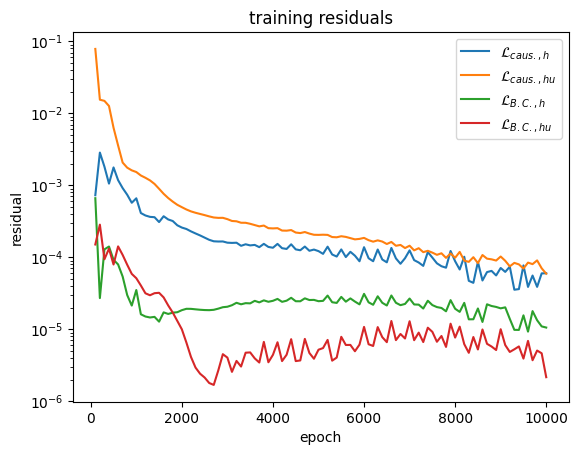

In [9]:
# plot residuals
plt.plot(epoch_list, residuals_list[:, 0], label=r'$\mathcal{L}_{caus.,h}$')
plt.plot(epoch_list, residuals_list[:, 1], label=r'$\mathcal{L}_{caus.,hu}$')
plt.plot(epoch_list, residuals_list[:, 2], label=r'$\mathcal{L}_{B.C.,h}$')
plt.plot(epoch_list, residuals_list[:, 3], label=r'$\mathcal{L}_{B.C.,hu}$')
plt.xlabel('epoch')
plt.ylabel('residual')
plt.title('training residuals')
plt.legend()
plt.yscale("log")